In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tables
import mplfinance as mpf
import my_afml_fncs as my_afml
# from AFML_Ch2_barchart import volume_bars_df
from my_afml_fncs import dropLabels, movingAverageCrossover
from research import drop_label
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report


Num of CPU core:  12
Machine info:  macOS-15.3.1-x86_64-i386-64bit
Python 3.11.9 | packaged by conda-forge | (main, Apr 19 2024, 18:45:13) [Clang 16.0.6 ]
Numpy 2.2.3
Pandas 2.2.3


In [5]:
filename_end="2019_2024"
# volume_bars_df = pd.read_hdf("tick_data/bars/volume_bars_50000.h5", key="volume_bars")
# volume_bars_df.head()
# volume_bars_df.shape
volume_bars_df=pd.read_csv(f'tick_data/bars/volume_bars_barchart_{filename_end}.csv')
volume_bars_df['bar_number'] = range(len(volume_bars_df))
dollar_bars_df=pd.read_csv(f'tick_data/bars/dollar_bars_barchart_{filename_end}.csv')
dollar_bars_df['bar_number'] = range(len(dollar_bars_df))

In [6]:
volume_bars_df['Date']=pd.to_datetime(volume_bars_df['Date'])
volume_bars_df.set_index('Date',inplace=True)
dollar_bars_df['Date']=pd.to_datetime(dollar_bars_df['Date'])
dollar_bars_df.set_index('Date',inplace=True)

dollar_bars_df.sort_index(inplace=True)
volume_bars_df.sort_index(inplace=True)


In [7]:
# get daily volatilities
vol=my_afml.getDailyVol(volume_bars_df.Close)
# vol.mean()
# vol.shape
dollar_vol=my_afml.getDailyVol(dollar_bars_df.Close)

In [8]:
# 3.1(a) apply CUSUM filet usings daily vols
es_cusum_events=my_afml.getTEvents(volume_bars_df.Close,vol.mean())
print('Volume bar CUSUM events:',es_cusum_events.shape)
dollar_es_cusum_events=my_afml.getTEvents(dollar_bars_df.Close,dollar_vol.mean())
print('Dollar bar CUSUM events:',dollar_es_cusum_events.shape)

Volume bar CUSUM events: (5595,)
Dollar bar CUSUM events: (37791,)


In [9]:
# 3.1(b) get the t1 vertical barriers, with 1-day
t1=my_afml.getVb(volume_bars_df.Close,es_cusum_events)
dollar_t1=my_afml.getVb(dollar_bars_df.Close,dollar_es_cusum_events)

In [10]:
# volume_bars_df.info()
# dollar_bars_df.info()

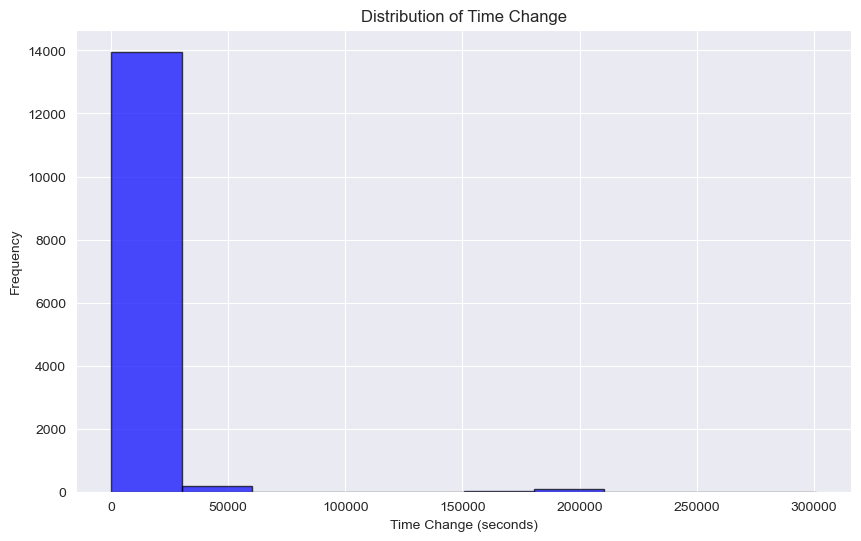

In [11]:
# Calculate change in bar number and time
volume_bars_df['bar_number_change'] = volume_bars_df['bar_number'].diff()
volume_bars_df['time_change'] = volume_bars_df.index.to_series().diff().dt.total_seconds()

# Plot histogram of time changes
plt.figure(figsize=(10, 6))
plt.hist(volume_bars_df['time_change'].dropna(), bins=10, color='blue', alpha=0.7, edgecolor='black')
plt.title('Distribution of Time Change')
plt.xlabel('Time Change (seconds)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [12]:
# this is unrelated to 3.3, trgt, trigger and bins
# 3.1(c) apply triple barrier method on the data with ptsl [1,1] and t1 as above, i assume target is daily vol
ptsl=[1,1]
trgt=vol.mean()*volume_bars_df.Close
minRet=0.00003
numThread=12
trigger=my_afml.getEvents(volume_bars_df.Close,es_cusum_events,ptsl,trgt,minRet,numThread,t1)
dollar_trigger=my_afml.getEvents(dollar_bars_df.Close,dollar_es_cusum_events,ptsl,trgt,minRet,numThread,dollar_t1)
# print(trigger,dollar_trigger)
print(trigger.shape,dollar_trigger.shape)



Running processJobs


2025-03-03 14:14:14.601182 100.0% applyPtSlOnT1 done after 0.02 minutes. Remaining 0.0 minutes..


Running processJobs


2025-03-03 14:14:18.963835 100.0% applyPtSlOnT1 done after 0.06 minutes. Remaining 0.0 minutes..


(835, 2) (15230, 2)


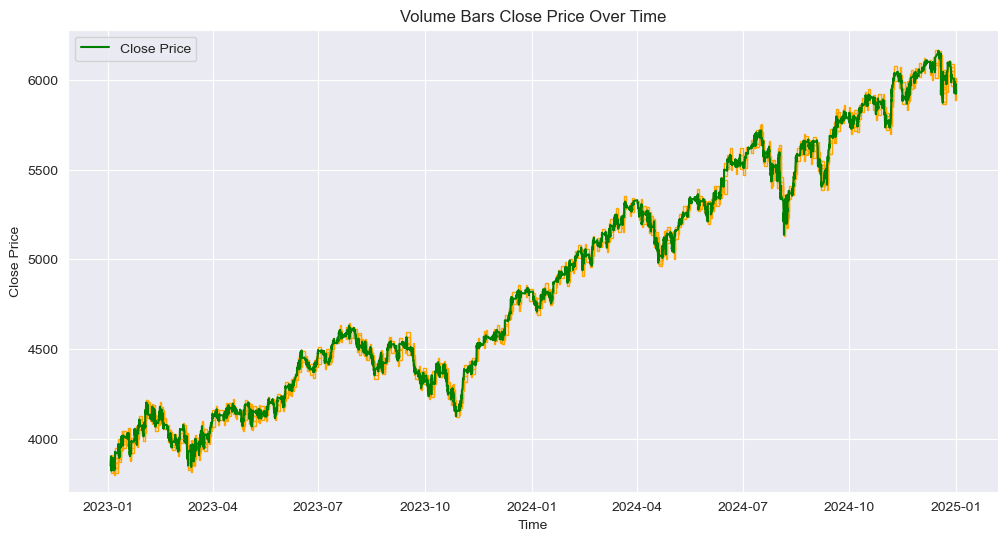

/Users/nicolasatkins/opt/anaconda3/envs/AFML/lib/python3.11/site-packages/mplfinance/_arg_validators.py:83: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


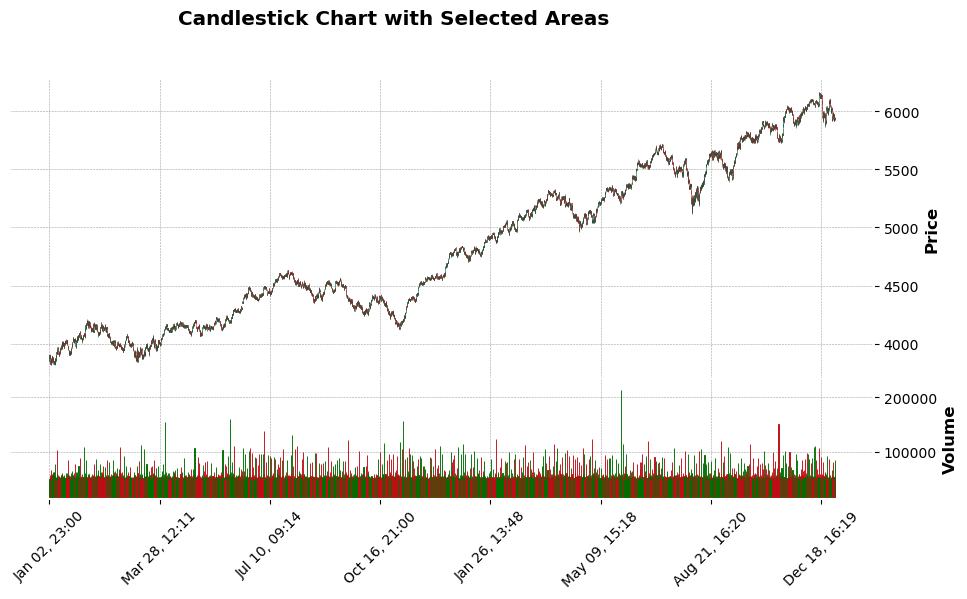

In [13]:
import mplfinance as mpf

plt.figure(figsize=(12, 6))
sns.lineplot(x=volume_bars_df.index, y='Close', data=volume_bars_df, label='Close Price', color='green')

for start, t1, trgt in trigger.itertuples():
    box = Rectangle((start, volume_bars_df.Close.loc[start] - vol.mean() * volume_bars_df.Close.loc[start]), t1 - start,
                    2 * vol.mean() * volume_bars_df.Close.loc[start],
                    linewidth=1, edgecolor='orange', facecolor='none', label='Selected Area')
    plt.gca().add_patch(box)

plt.xlabel('Time')
plt.ylabel('Close Price')
plt.title('Volume Bars Close Price Over Time')
# plt.legend()
plt.grid(True)
plt.show()

# New mplfinance plot
ap_boxes = []
for start, t1, trgt in trigger.itertuples():
    ap_boxes.append(mpf.make_addplot(
        [[volume_bars_df.Close.loc[start],
          volume_bars_df.Close.loc[start] + 2 * vol.mean() * volume_bars_df.Close.loc[start]]],
        linestyle="dashed", color='orange'
    ))

mpf.plot(volume_bars_df, type='candle', style='charles', title='Candlestick Chart with Selected Areas',
          volume=True, figsize=(12, 6))



In [14]:
# 3.1(d) apply getBins to generate labels
bins=my_afml.getBins(trigger,volume_bars_df.Close)
dollar_bins=my_afml.getBins(dollar_trigger,dollar_bars_df.Close)
# bins.head()

In [15]:
# 3.2 drop rare labels
post_drop_bins=dropLabels(bins)
post_drop_bins.head()
post_drop_dollar_bins=dropLabels(dollar_bins)
post_drop_dollar_bins.head()

dropped label 2 0.004796163069544364
dropped label 2 0.00375345713156855


,ret,bin
2023-01-02 23:07:00,-0.012468,-1.0
2023-01-02 23:10:00,-0.010053,-1.0
2023-01-02 23:21:00,-0.007876,-1.0
2023-01-03 00:11:00,-0.005753,-1.0
2023-01-03 00:52:00,-0.003887,-1.0


START OF MODEL FOR META_LABELS

In [16]:
# Start of 3.4
# Define moving average windows
short_window = 5  # e.g., 50 periods
long_window = 20  # e.g., 200 periods

In [17]:
# create events where the moving averages cross over
events = my_afml.movingAverageCrossover(volume_bars_df.Close, short_window, long_window)
# events.head()
# try this with a crossover signa change
events['signal_switch'] = events.signal.diff() / 2
# drop rows with any NaN values
events = events.dropna()
# filter rows where signal_switch is not zero
events = events[events['signal_switch'] != 0]
events.head()

,short_ma,long_ma,signal,signal_switch
time,,,,
2023-01-03 11:46:00,3881.50,3876.208333,1,1.0
2023-01-03 14:57:00,3873.90,3876.346154,-1,-1.0
2023-01-03 20:34:00,3843.15,3839.550000,1,1.0
2023-01-04 15:29:00,3851.60,3853.512500,-1,-1.0
2023-01-04 16:11:00,3860.40,3857.525000,1,1.0


In [18]:
# create events where the moving averages cross over
dollar_events = my_afml.movingAverageCrossover(dollar_bars_df.Close, short_window, long_window)
# events.head()
# try this with a crossover signa change
dollar_events['signal_switch'] = dollar_events.signal.diff() / 2
# drop rows with any NaN values
dollar_events = dollar_events.dropna()
# filter rows where signal_switch is not zero
dollar_events = dollar_events[dollar_events['signal_switch'] != 0]
dollar_events.head()

,short_ma,long_ma,signal,signal_switch
time,,,,
2023-01-02 23:09:00,3887.75,3887.475000,1,1.0
2023-01-02 23:10:00,3886.25,3886.727273,-1,-1.0
2023-01-03 00:01:00,3870.80,3870.575000,1,1.0
2023-01-03 00:05:00,3870.25,3870.400000,-1,-1.0
2023-01-03 00:34:00,3865.30,3865.100000,1,1.0


In [19]:
# and add vertical barrier 1 day from those events (as close to 1 day as possible?)
t1=my_afml.getVb(volume_bars_df.Close,events.index)
dollar_t1=my_afml.getVb(dollar_bars_df.Close,dollar_events.index)

In [20]:
# Now create the meta-labels using the primary model (which provides the side from the crossover point), the t1 vertical barrier which is as close to 1 day as possible from the crossover. We dont label anything as primary model as that was the simple crossover. Meta-labels are used to for secondary model.
# now set ptsl to be lopsided [1,2] which we can do because we now have a 'side' from the moving average crossover. Trigger has column called 'side'
ptsl=[1,2]
# target is set to be standard deviation
trgt=vol.mean()*volume_bars_df.Close
# not sure about min return
minRet=0.00003
numThread=24
# get events will find time of first touch after each event
trigger_secondary_model=my_afml.getEvents(volume_bars_df.Close,events.index,ptsl,trgt,minRet,numThread,t1,events.signal)

Running processJobs


2025-03-03 14:15:47.370823 100.0% applyPtSlOnT1 done after 0.03 minutes. Remaining 0.0 minutes..


In [21]:
#and for dollar bars
ptsl=[1,2]
# target is set to be standard deviation
dollar_trgt=dollar_vol.mean()*dollar_bars_df.Close
# not sure about min return
minRet=0.00003
numThread=24
# get events will find time of first touch after each event
dollar_trigger_secondary_model=my_afml.getEvents(dollar_bars_df.Close,dollar_events.index,ptsl,dollar_trgt,minRet,numThread,t1,dollar_events.signal)

Running processJobs


025-03-03 14:16:13.662200 41.67% applyPtSlOnT1 done after 0.42 minutes. Remaining 0.58 minutes.2025-03-03 14:16:18.490384 50.0% applyPtSlOnT1 done after 0.5 minutes. Remaining 0.5 minutes.2025-03-03 14:16:20.675172 58.33% applyPtSlOnT1 done after 0.53 minutes. Remaining 0.38 minutes.2025-03-03 14:16:22.276245 66.67% applyPtSlOnT1 done after 0.56 minutes. Remaining 0.28 minutes.2025-03-03 14:16:23.285265 75.0% applyPtSlOnT1 done after 0.58 minutes. Remaining 0.19 minutes.2025-03-03 14:16:24.430611 83.33% applyPtSlOnT1 done after 0.6 minutes. Remaining 0.12 minutes.2025-03-03 14:16:24.997217 91.67% applyPtSlOnT1 done after 0.61 minutes. Remaining 0.06 minutes.


In [22]:
trigger_secondary_model.head()

,t1,trgt,side
time,,,
2023-01-03 11:46:00,2023-01-04 12:07:00,26.663222,1
2023-01-03 14:57:00,2023-01-04 14:57:00,26.496576,-1
2023-01-03 20:34:00,2023-01-04 20:43:00,26.424421,1
2023-01-04 15:29:00,2023-01-05 15:31:00,26.448473,-1
2023-01-04 16:11:00,2023-01-05 16:20:00,26.613400,1


In [23]:
dollar_trigger_secondary_model.head()

,t1,trgt,side
time,,,
2023-01-02 23:09:00,NaT,6.050408,1.0
2023-01-02 23:10:00,NaT,6.041453,-1.0
2023-01-03 00:01:00,NaT,6.027048,1.0
2023-01-03 00:05:00,NaT,6.026269,-1.0
2023-01-03 00:34:00,NaT,6.021208,1.0


In [24]:
# getBins will generate the meta-label as we provide a side now in trigger
bins_secondary_model=my_afml.getBins(trigger_secondary_model,volume_bars_df.Close)
dollar_bins_secondary_model=my_afml.getBins(dollar_trigger_secondary_model,dollar_bars_df.Close)

In [25]:
bins_secondary_model.head()
dollar_bins_secondary_model.head()

,ret,bin
time,,
2023-01-04 19:23:00,0.004397,1.0
2023-01-10 17:01:00,-0.014262,0.0
2023-01-12 16:41:00,0.000188,1.0
2023-01-19 18:28:00,-0.007526,0.0
2023-01-31 14:33:00,0.008848,1.0


In [26]:
# add the crossover data and std to volume_bars for the secondary model
volume_bars_df[['short_ma', 'long_ma', 'signal']] = my_afml.movingAverageCrossover(volume_bars_df.Close, short_window, long_window)
volume_bars_df['std']=my_afml.getDailyVol(volume_bars_df.Close)
# volume_bars_df.head()

In [27]:
dollar_bars_df[['short_ma', 'long_ma', 'signal']] = my_afml.movingAverageCrossover(dollar_bars_df.Close, short_window, long_window)
dollar_bars_df['std']=my_afml.getDailyVol(dollar_bars_df.Close)
# volume_bars_df.head()

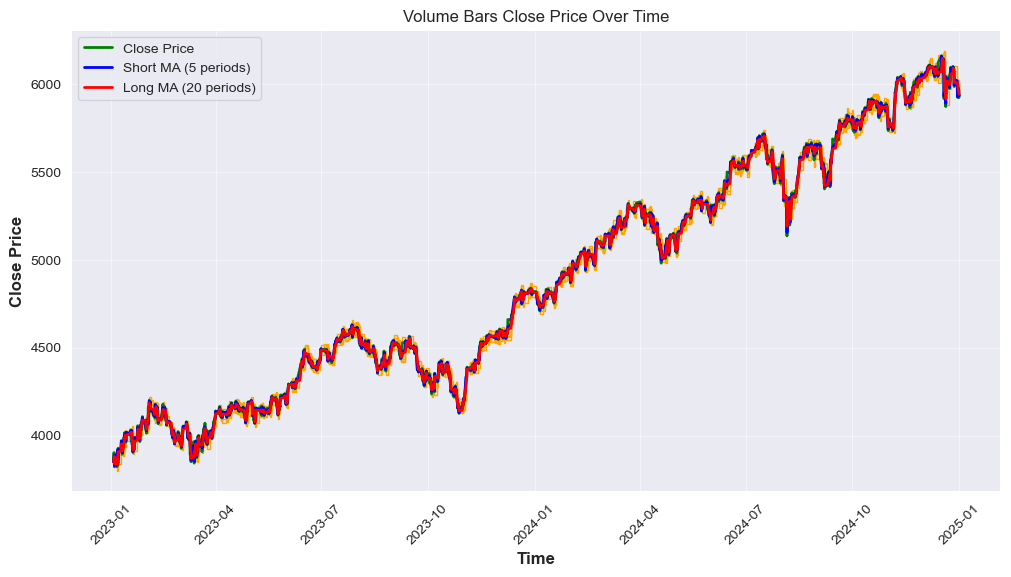

In [28]:
plt.figure(figsize=(12, 6))
sns.lineplot(x=volume_bars_df.index, y='Close', data=volume_bars_df, label='Close Price', color='green')
sns.lineplot(x=volume_bars_df.index, y='short_ma', data=volume_bars_df, label='Short MA (5 periods)', color='blue')
sns.lineplot(x=volume_bars_df.index, y='long_ma', data=volume_bars_df, label='Long MA (20 periods)', color='red')

for start, t1, trgt, _ in trigger_secondary_model.itertuples():
    box = Rectangle((start, volume_bars_df.Close.loc[start] - vol.mean() * volume_bars_df.Close.loc[start]), t1 - start,
                    2 * vol.mean() * volume_bars_df.Close.loc[start],
                    linewidth=1, edgecolor='orange', facecolor='none', label='Selected Area')
    plt.gca().add_patch(box)

plt.xlabel('Time')
plt.ylabel('Close Price')
plt.title('Volume Bars Close Price Over Time')
plt.xticks(rotation=45)
# plt.legend()
plt.grid(True)
plt.show()


In [29]:
# now fit same data using these labels
X=volume_bars_df.loc[bins_secondary_model.index,:]
y=bins_secondary_model['bin']

In [30]:


# Prepare the data
features = X
features = features.drop(columns=['Time'])
labels =y  # Target variable
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=42)

# Train RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predict and evaluate
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(classification_report(y_test, y_pred))

Accuracy: 0.44565217391304346
              precision    recall  f1-score   support

         0.0       0.45      0.51      0.48       136
         1.0       0.45      0.38      0.41       140

    accuracy                           0.45       276
   macro avg       0.45      0.45      0.44       276
weighted avg       0.45      0.45      0.44       276



In [31]:
# now fit same data using these labels
X=dollar_bars_df.loc[dollar_bins_secondary_model.index,:]
y=dollar_bins_secondary_model['bin']

In [32]:

# Prepare the data
features = X
features = features.drop(columns=['Time'])
labels =y  # Target variable
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=42)

# Train RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predict and evaluate
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(classification_report(y_test, y_pred))

Accuracy: 0.75
              precision    recall  f1-score   support

         0.0       0.73      0.89      0.80         9
         1.0       0.80      0.57      0.67         7

    accuracy                           0.75        16
   macro avg       0.76      0.73      0.73        16
weighted avg       0.76      0.75      0.74        16



In [ ]:
# try this 4
print(accuracy_score(y_test, y_pred))